## Kaggle Fast Model Flow

In [404]:
import pandas as pd
import numpy as np
import glob, re
from datetime import datetime
from xgboost import XGBRegressor
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold,StratifiedKFold, TimeSeriesSplit
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
%matplotlib inline
plt.rcParams.update({'font.size': 15,
                     'axes.labelsize':22,
                     'axes.titlesize':25,
                     'ytick.labelsize':22,
                     'xtick.labelsize':15})
import h2o
from h2o.automl import H2OAutoML
import warnings

In [372]:
warnings.filterwarnings('ignore')

In [2]:
data = {
    'tra': pd.read_csv('data/air_visit_data.csv'),
    'as': pd.read_csv('data/air_store_info.csv'),
    'hs': pd.read_csv('data/hpg_store_info.csv'),
    'ar': pd.read_csv('data/air_reserve.csv'),
    'hr': pd.read_csv('data/hpg_reserve.csv'),
    'id': pd.read_csv('data/store_id_relation.csv'),
    'tes': pd.read_csv('data/sample_submission.csv'),
    'hol': pd.read_csv('data/date_info.csv').rename(columns={'calendar_date':'visit_date'})
    }

### Data Explanation
Data is coming from two seperate foodie sites:
   * Hot Pepper Gourmet (hpg)
   * AirREGI (air)
   
Explanation for csv files:
- **"air_reserve.csv":** Reservations made with "air system".
- **"hpg_reserve.csv":** Reservations made with "hpg system".
- **"air_store_info.csv":** Information about ***air*** restaurants. (Id, Genre, Lat-Long, Area)
- **"hpg_store_info.csv":** Information about ***hpg*** restaurants. (Id, Genre, Lat-Long, Area)
- **"store_id_relation.csv":** Relation of restaurants to our two reservation systems.
- **"air_visit_data.csv":** Historical visit data from ***air*** with dates and visitor counts given the restaurant IDs.
- **"date_info":** Basic information about the calendar dates in the dataset.

### Data Preperation

* ***air*** is a dedicated reservation system whereas hpg is like Yelp: Dedicated for restaurant rewievs and reservation is possible.
* As a result hgp does not contain visitor count. so no labels. 
* Labeled data formed by merging restaurants with common data.

In [3]:
data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])

- Aggregate restaurant and visit days over sum and mean values visitor count and days between reservation-visit.
- | air_store_id | visit_date | sum difference | sum reserved visitors | mean difference | mean reserved visitors |

In [4]:
for df in ['ar','hr']:
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime'])
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date
    data[df]['reserve_datetime_diff'] = data[df].apply(lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
    tmp1 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].sum().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs1', 'reserve_visitors':'rv1'})
    tmp2 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].mean().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs2', 'reserve_visitors':'rv2'})
    data[df] = pd.merge(tmp1, tmp2, how='inner', on=['air_store_id','visit_date'])

In [5]:
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek
data['tra']['year'] = data['tra']['visit_date'].dt.year
data['tra']['month'] = data['tra']['visit_date'].dt.month
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date

data['tes']['visit_date'] = data['tes']['id'].map(lambda x: str(x).split('_')[2])
data['tes']['air_store_id'] = data['tes']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek
data['tes']['year'] = data['tes']['visit_date'].dt.year
data['tes']['month'] = data['tes']['visit_date'].dt.month
data['tes']['visit_date'] = data['tes']['visit_date'].dt.date

In [6]:
unique_stores = data['tes']['air_store_id'].unique()
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)

In [7]:
#sure it can be compressed...
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].min().rename(columns={'visitors':'min_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].mean().rename(columns={'visitors':'mean_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].median().rename(columns={'visitors':'median_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].max().rename(columns={'visitors':'max_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].count().rename(columns={'visitors':'count_observations'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 

stores = pd.merge(stores, data['as'], how='left', on=['air_store_id']) 
# NEW FEATURES FROM Georgii Vyshnia
stores['air_genre_name'] = stores['air_genre_name'].map(lambda x: str(str(x).replace('/',' ')))
stores['air_area_name'] = stores['air_area_name'].map(lambda x: str(str(x).replace('-',' ')))
lbl = preprocessing.LabelEncoder()
for i in range(10):
    stores['air_genre_name'+str(i)] = lbl.fit_transform(stores['air_genre_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
    stores['air_area_name'+str(i)] = lbl.fit_transform(stores['air_area_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

data['hol']['day_of_week'] = data['hol']['day_of_week'].map({'Monday':'0_Monday',
                            'Tuesday':'1_Tuesday',
                            'Wednesday':'2_Wednesday',
                            'Thursday':'3_Thursday',
                            'Friday':'4_Friday',
                            'Saturday':'5_Saturday',
                            'Sunday':'6_Sunday'})
data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week'])
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date
train = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date']) 
test = pd.merge(data['tes'], data['hol'], how='left', on=['visit_date']) 

train = pd.merge(train, stores, how='left', on=['air_store_id','dow']) 
test = pd.merge(test, stores, how='left', on=['air_store_id','dow'])

for df in ['ar','hr']:
    train = pd.merge(train, data[df], how='left', on=['air_store_id','visit_date']) 
    test = pd.merge(test, data[df], how='left', on=['air_store_id','visit_date'])

train['id'] = train.apply(lambda r: '_'.join([str(r['air_store_id']), str(r['visit_date'])]), axis=1)

train['total_reserv_sum'] = train['rv1_x'] + train['rv1_y']
train['total_reserv_mean'] = (train['rv2_x'] + train['rv2_y']) / 2
train['total_reserv_dt_diff_mean'] = (train['rs2_x'] + train['rs2_y']) / 2

test['total_reserv_sum'] = test['rv1_x'] + test['rv1_y']
test['total_reserv_mean'] = (test['rv2_x'] + test['rv2_y']) / 2
test['total_reserv_dt_diff_mean'] = (test['rs2_x'] + test['rs2_y']) / 2

# NEW FEATURES FROM JMBULL
train['date_int'] = train['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
test['date_int'] = test['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
train['var_max_lat'] = train['latitude'].max() - train['latitude']
train['var_max_long'] = train['longitude'].max() - train['longitude']
test['var_max_lat'] = test['latitude'].max() - test['latitude']
test['var_max_long'] = test['longitude'].max() - test['longitude']

# NEW FEATURES FROM Georgii Vyshnia
train['lon_plus_lat'] = train['longitude'] + train['latitude'] 
test['lon_plus_lat'] = test['longitude'] + test['latitude']

lbl = preprocessing.LabelEncoder()
train['air_store_id2'] = lbl.fit_transform(train['air_store_id'])
test['air_store_id2'] = lbl.transform(test['air_store_id'])

col = [c for c in train if c not in ['id', 'air_store_id', 'visit_date','visitors']]
train = train.fillna(-1)
test = test.fillna(-1)

### Apply Base Regression Models

In [381]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

In [382]:
scaler = preprocessing.MinMaxScaler()
scaled_train = scaler.fit_transform(train[col])
scaler = preprocessing.MinMaxScaler()
scaled_test = scaler.fit_transform(test[col])

In [405]:
model_lin_reg = LinearRegression(n_jobs=-1,normalize=True)
model_knn_reg = KNeighborsRegressor(n_jobs=-1,n_neighbors=6)

In [406]:
model1 = model_lin_reg.fit(train[col], np.log1p(train['visitors'].values))

In [ ]:
model2 = model_knn_reg.fit(train[col], np.log1p(train['visitors'].values))

In [407]:
lin_reg_test_pred = model1.predict(test[col])

In [210]:
knn_reg_test_pred = model2.predict(test[col])

In [408]:
sub1 = pd.read_csv('data/sample_submission.csv')
sub1.visitors = np.expm1(lin_reg_test_pred)
sub1.to_csv('submissions/linear_reg.csv',index=False)

In [211]:
sub2 = pd.read_csv('data/sample_submission.csv')
sub2.visitors = np.expm1(knn_reg_test_pred)
sub2.to_csv('submissions/knn_reg.csv',index=False)

In [91]:
data = {'LinReg':0.601,
          'KNN_Reg':0.593}

<Container object of 2 artists>

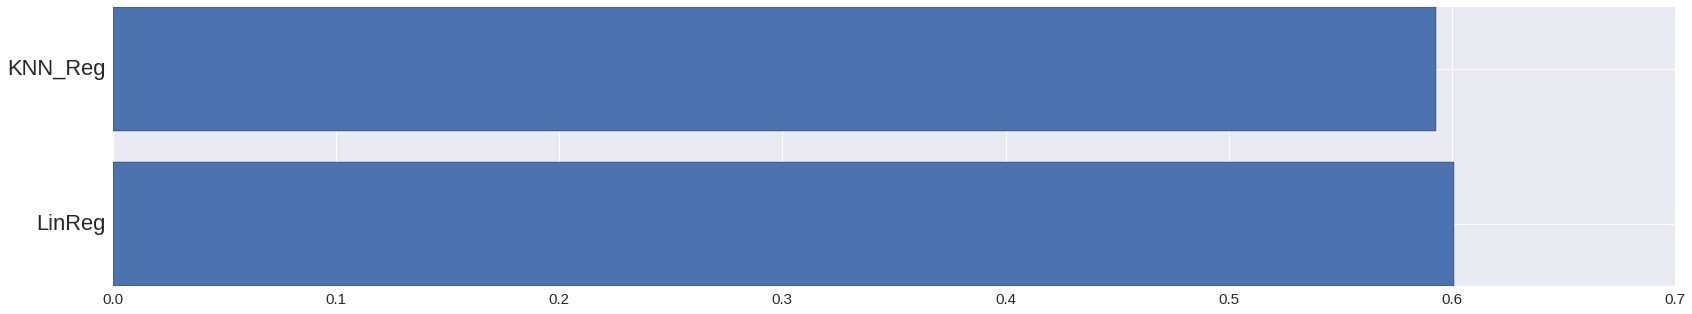

In [101]:
names = list(data.keys())
values = list(data.values())
#tick_label does the some work as plt.xticks()
plt.figure(figsize=(28,5))
plt.barh(range(len(data)),values,tick_label=names,align='center')

### Apply Sklearn Ensemble Models

- Single model is not enough.
- Meta-algorithms that combine base learners.
- Diversification is the key


In [402]:
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,ExtraTreesRegressor

In [252]:
model_rfr = RandomForestRegressor(n_estimators=1000,max_depth=6,verbose=1,min_samples_split=2,n_jobs=-1,random_state=42)
model_etr = ExtraTreesRegressor(n_estimators=1000,max_depth=6,verbose=1,min_samples_split=2,n_jobs=-1,random_state=42)

In [253]:
print('Fitting Random Forest')
model4 = model_rfr.fit(train[col], np.log1p(train['visitors'].values))
print('Fitting Extra Trees')
model5 = model_etr.fit(train[col], np.log1p(train['visitors'].values))

Fitting Random Forest


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   35.0s finished


Fitting Extra Trees


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   24.4s finished


In [254]:
rfr_test_pred = model4.predict(test[col])
etr_test_pred = model5.predict(test[col])

[Parallel(n_jobs=48)]: Using backend ThreadingBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:    0.1s
[Parallel(n_jobs=48)]: Done 354 tasks      | elapsed:    0.1s
[Parallel(n_jobs=48)]: Done 704 tasks      | elapsed:    0.2s
[Parallel(n_jobs=48)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=48)]: Using backend ThreadingBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done 104 tasks      | elapsed:    0.1s
[Parallel(n_jobs=48)]: Done 354 tasks      | elapsed:    0.1s
[Parallel(n_jobs=48)]: Done 704 tasks      | elapsed:    0.3s
[Parallel(n_jobs=48)]: Done 1000 out of 1000 | elapsed:    0.3s finished


In [255]:
sub4 = pd.read_csv('data/sample_submission.csv')
sub4.visitors = np.expm1(rfr_test_pred)
sub4.to_csv('submissions/random_forest.csv',index=False)

sub5 = pd.read_csv('data/sample_submission.csv')
sub5.visitors = np.expm1(etr_test_pred)
sub5.to_csv('submissions/extra_trees.csv',index=False)

In [102]:
data = {'Random Forest 1':0.665,
          'Extra Trees 1':0.665,
          'Random Forest 2':0.589,
          'Extra Trees 2':0.626,
          'Random Forest 3':0.558,
          'Extra Trees 3':0.559}

<Container object of 6 artists>

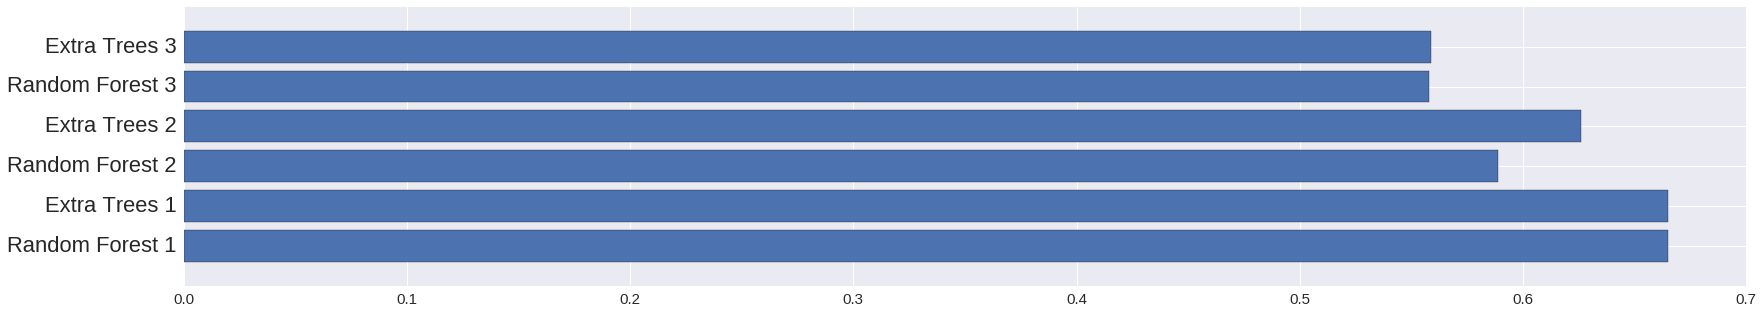

In [103]:
names = list(data.keys())
values = list(data.values())
#tick_label does the some work as plt.xticks()
plt.figure(figsize=(28,5))
plt.barh(range(len(data)),values,tick_label=names,align='center')

### Apply Sklearn Tree Boosters for Regression

- Serial application of tree based learners.
- Weak models are produced and improved over time by weighted samples
- Misclassified instances are weighed more in next iteration.
- [Tree Training Visualized](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
- [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) 
- [Gradient Boosting Playground](http://arogozhnikov.github.io/2016/07/05/gradient_boosting_playground.html)



![title](images/Picture1.png)

In [403]:
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor

In [271]:
model_ada = AdaBoostRegressor(n_estimators=100,loss='square',learning_rate=0.001)
model_gdb = GradientBoostingRegressor(n_estimators=1000,max_depth=6,learning_rate=0.001,verbose=1)

In [ ]:
print('Fitting Ada Boost')
model7 = model_ada.fit(train[col], np.log1p(train['visitors'].values))

In [272]:
print('Fitting Gradient Boosting')
model8 = model_gdb.fit(train[col], np.log1p(train['visitors'].values))

Fitting Gradient Boosting
      Iter       Train Loss   Remaining Time 
         1           0.6516           23.96m
         2           0.6509           24.25m
         3           0.6501           24.43m
         4           0.6493           24.64m
         5           0.6486           24.61m
         6           0.6478           24.66m
         7           0.6470           24.61m
         8           0.6463           24.60m
         9           0.6455           24.63m
        10           0.6448           24.83m
        20           0.6373           24.35m
        30           0.6299           24.13m
        40           0.6227           23.82m
        50           0.6156           23.56m
        60           0.6087           23.34m
        70           0.6019           23.07m
        80           0.5952           22.76m
        90           0.5887           22.49m
       100           0.5823           22.26m
       200           0.5248           19.86m
       300           0.4776 

In [273]:
ada_test_pred = model7.predict(test[col])
gdb_test_pred = model8.predict(test[col])

In [274]:
sub7 = pd.read_csv('data/sample_submission.csv')
sub7.visitors = np.expm1(ada_test_pred)
sub7.to_csv('submissions/adaboost.csv',index=False)

sub8 = pd.read_csv('data/sample_submission.csv')
sub8.visitors = np.expm1(gdb_test_pred)
sub8.to_csv('submissions/gbm.csv',index=False)

In [104]:
data = {'AdaBoost':0.577,
        'Gradient Boost':0.596}

<Container object of 2 artists>

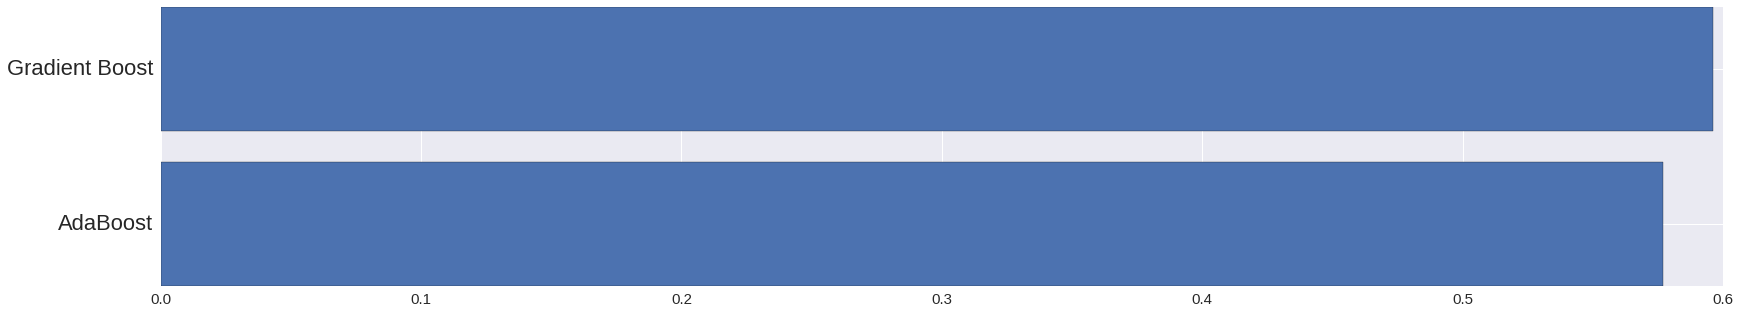

In [105]:
names = list(data.keys())
values = list(data.values())
#tick_label does the some work as plt.xticks()
plt.figure(figsize=(28,5))
plt.barh(range(len(data)),values,tick_label=names,align='center')

### Apply Famous Boosters 

- **XGBoost** by DMLC
    - Supports the distributed processing frameworks Apache Hadoop, Apache Spark, and Apache Flink. 
- **LightGBM** by Microsoft
    - Faster training lower memory usage
- **CatBoost** by Yandex
    - Support for handling categorical variables
    - Process Visualisation


#### XGBoost

In [292]:
import xgboost as xgb

In [293]:
train_matrix = xgb.DMatrix(train[col],label=np.log1p(train['visitors']))

In [294]:
params = {'n_estimators':1000,
'max_depth':6,
'base_score':np.mean(np.log1p(train['visitors'])),
'learning_rate':0.02,
'n_jobs':48,
'max_delta_step':6,
'subsample':0.7,
#colsample_bylevel = 0.8,
'colsample_bytree':0.7,
#seed=666,
'reg_alpha':0.01,
'reg_lambda':2.5}

In [295]:
xgb_model = xgb.train(params,train_matrix,num_boost_round=1000)

In [296]:
def get_importance_plot(booster, figsize, **kwargs): 
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return xgb.plot_importance(booster=booster,importance_type='gain' ,ax=ax, **kwargs,max_num_features=50)

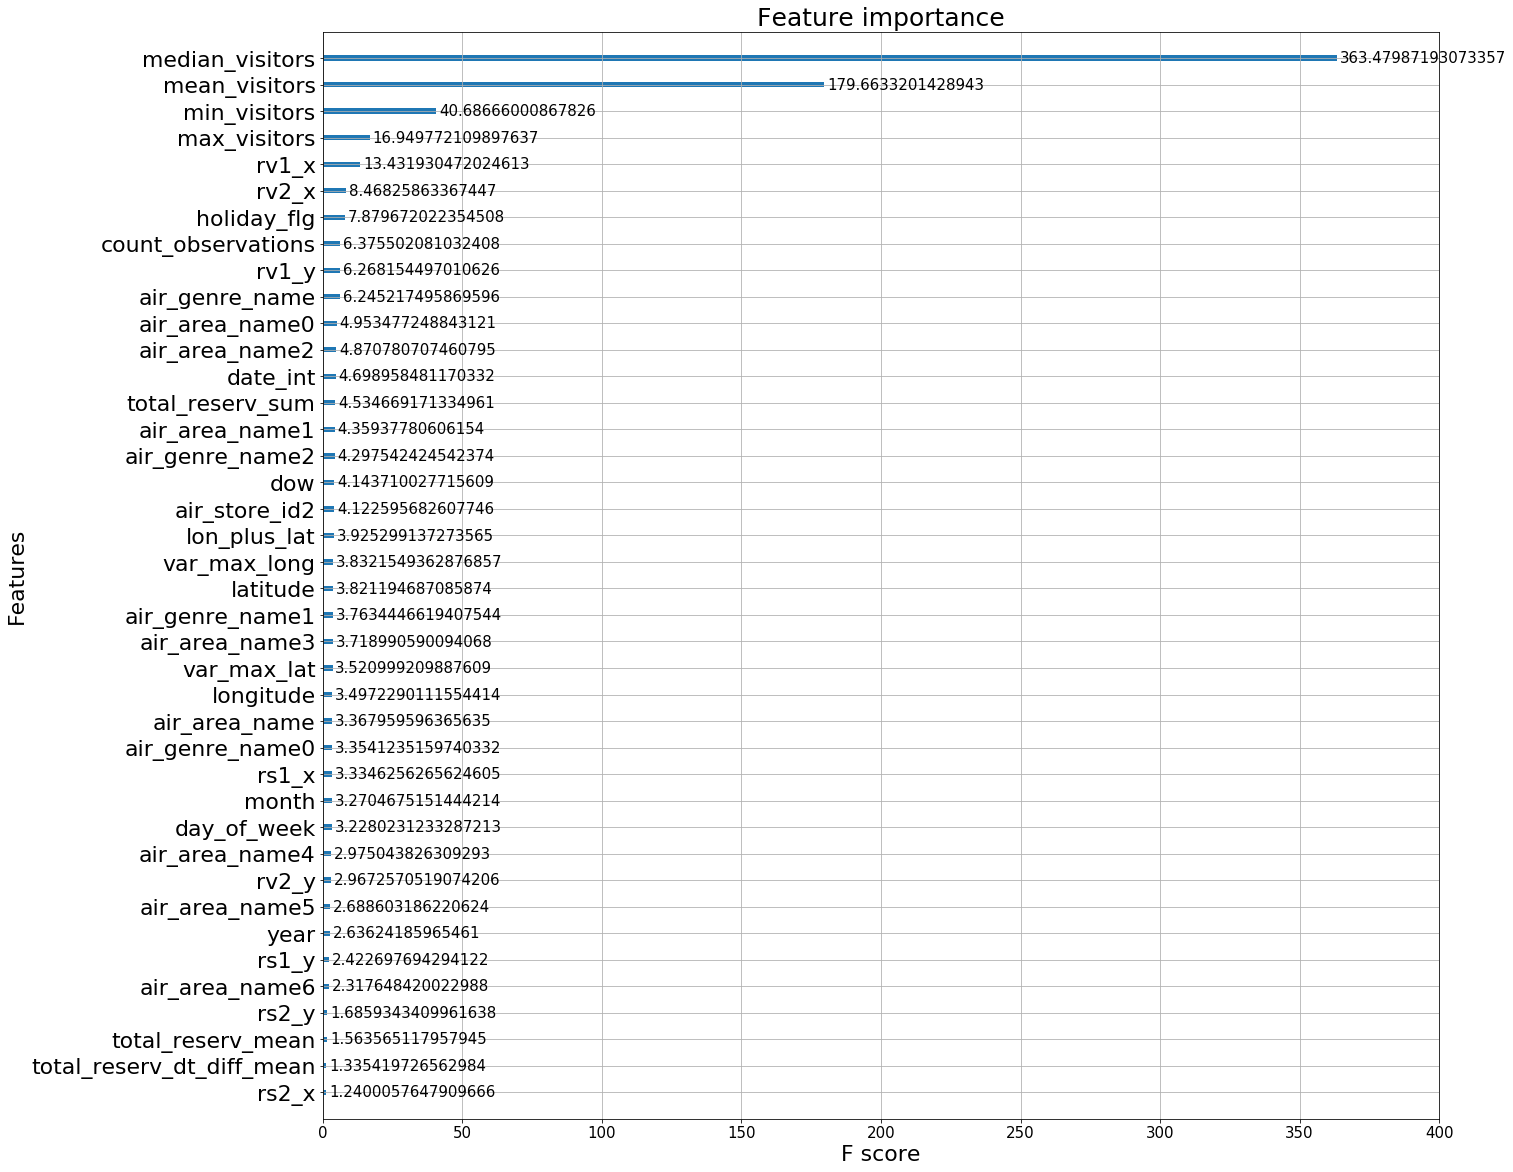

In [21]:
get_importance_plot(xgb_model,(20,20))

In [22]:
test_matrix = xgb.DMatrix(test[col])
xgb_test_pred = xgb_model.predict(test_matrix)

In [23]:
sub9 = pd.read_csv('data/sample_submission.csv')
sub9.visitors = np.expm1(xgb_test_pred)
sub9.to_csv('submissions/xgb.csv',index=False)

#### LightGBM

In [24]:
import lightgbm as lgb

In [25]:
train_matrix = lgb.Dataset(train[col],label=np.log1p(train['visitors']))

In [26]:
lgb_params = {"n_jobs":-1,
            "n_estimators":1000,
            "learning_rate":0.02,
            "num_leaves":10,
            "colsample_bytree":0.7,
            "subsample":0.7,
            "max_depth":6,
            "reg_alpha":0.01,
            "reg_lambda":2.5,
            "silent":-1,
            "verbose":-1,
            "random_state":1881}

In [27]:
lgb_model = lgb.train(lgb_params,train_matrix,num_boost_round=1000)

/home/dorukhan/anaconda2/envs/richmansworld/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/dorukhan/anaconda2/envs/richmansworld/lib/python3.6/site-packages/lightgbm/basic.py:657: UserWarning: silent keyword has been found in `params` and will be ignored. Please use silent argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


In [28]:
def get_importance_plot(booster, figsize, **kwargs): 
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return lgb.plot_importance(booster=booster,importance_type='gain' ,ax=ax, **kwargs,max_num_features=50)

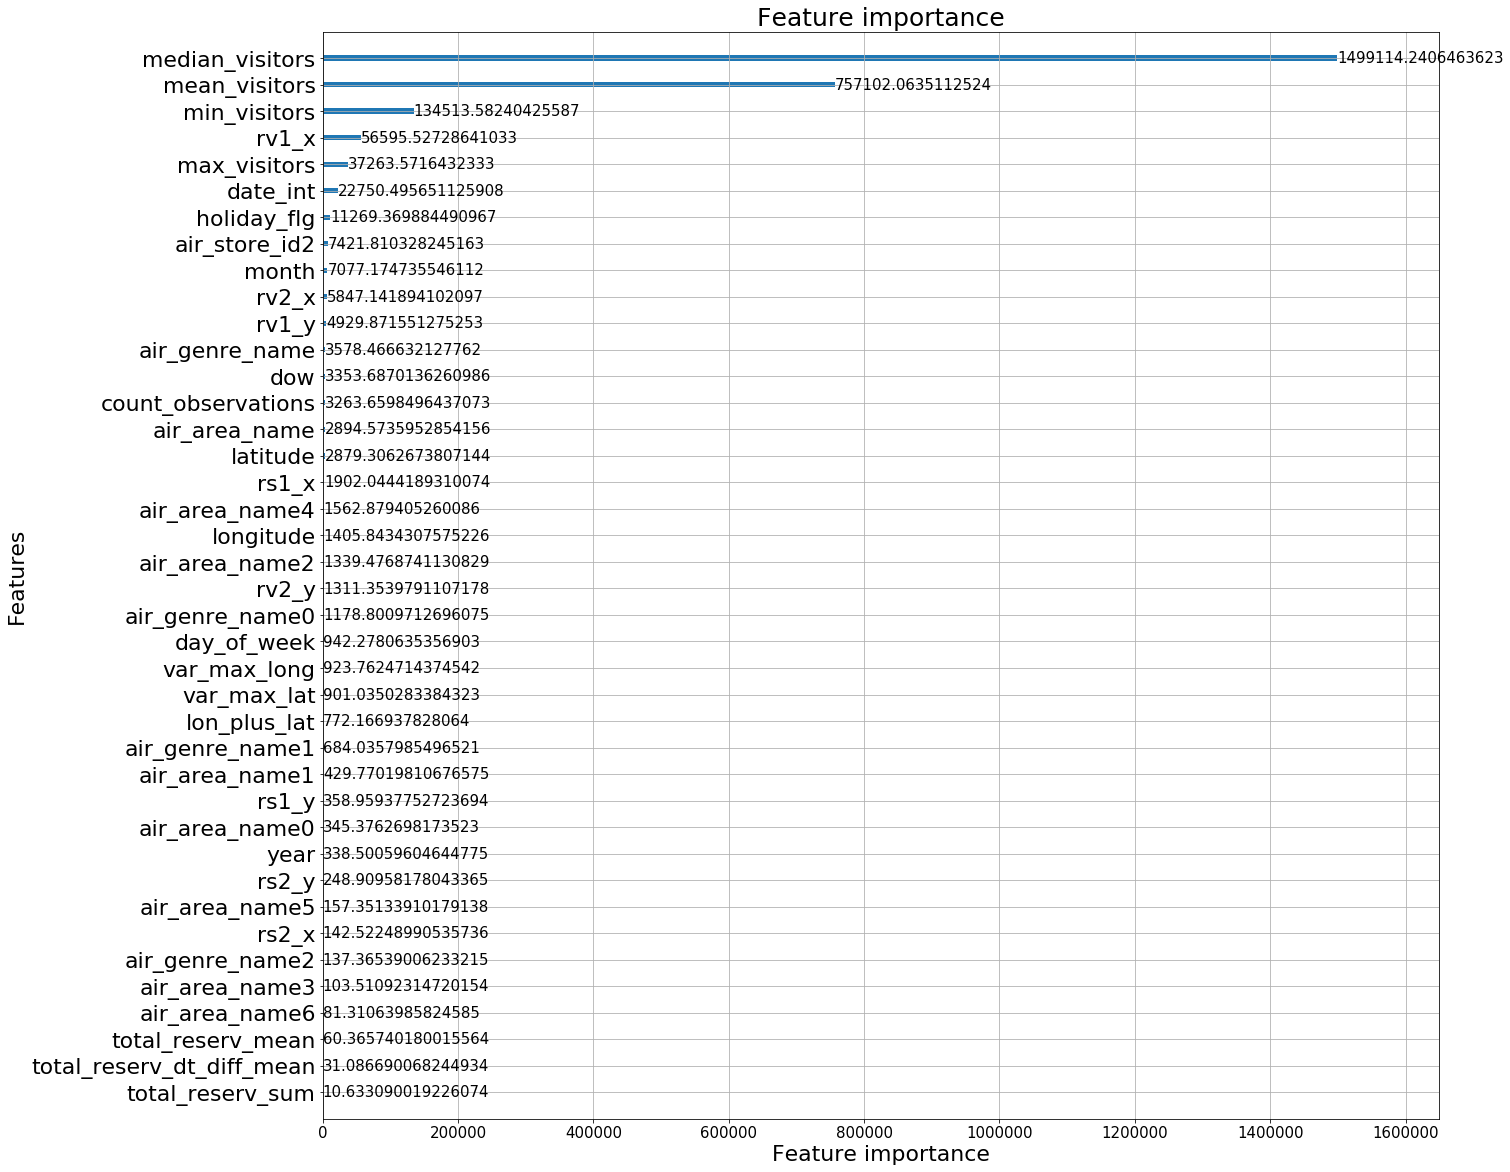

In [29]:
get_importance_plot(lgb_model,(20,20))

In [30]:
lgb_test_pred = lgb_model.predict(test[col])

In [31]:
sub10 = pd.read_csv('data/sample_submission.csv')
sub10.visitors = np.expm1(lgb_test_pred)
sub10.to_csv('submissions/lgb.csv',index=False)

In [32]:
data = {'LinReg':0.601,
          'KNN_Reg':0.593,
          'Random Forest 1':0.665,
          'Extra Trees 1':0.665,
          'Random Forest 2':0.589,
          'Extra Trees 2':0.626,
          'Random Forest 3':0.558,
          'Extra Trees 3':0.559,
          'AdaBoost':0.577,
          'Gradient Boost':0.596,
          'XGBoost':0.551,
          'LightGBM':0.551,
          'XGBoost 2':0.550,
          'LightGBM 2':0.549,
          'XGBoost 3':0.542,
          'LightGBM 3':0.547}

<BarContainer object of 16 artists>

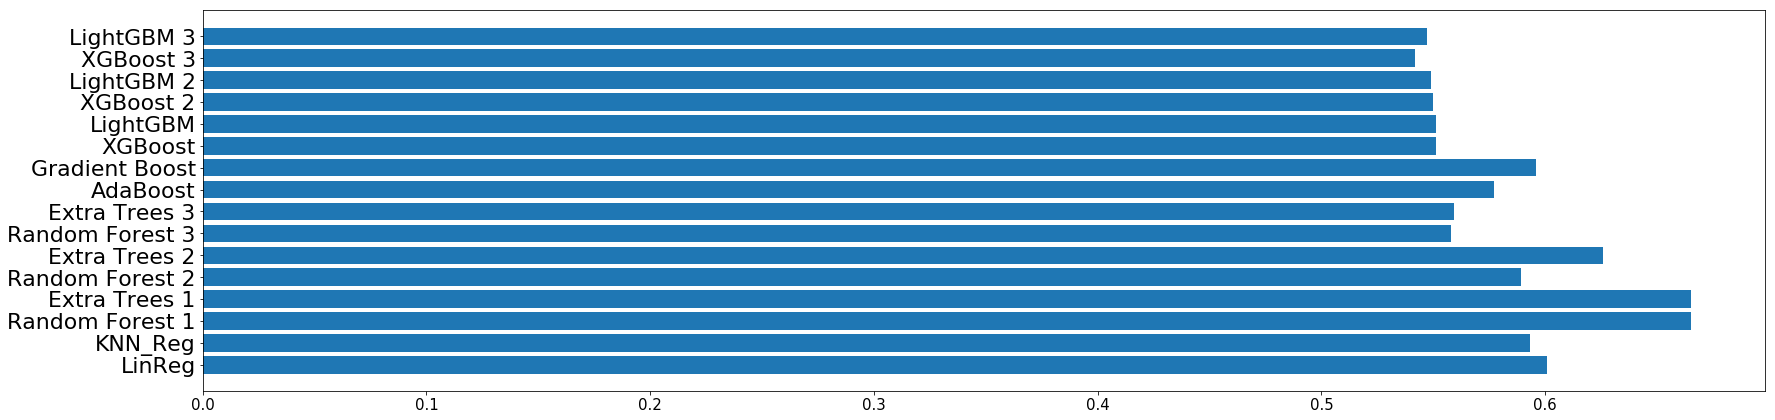

In [33]:
names = list(data.keys())
values = list(data.values())

#tick_label does the some work as plt.xticks()
plt.figure(figsize=(28,7))
plt.barh(range(len(data)),values,tick_label=names,align='center',)

#### CatBoost

In [34]:
import catboost as ctb
from catboost import Pool

In [35]:
cat_cols = ['air_genre_name','air_area_name','air_genre_name0','air_area_name0','air_genre_name2','air_area_name2',
 'air_genre_name3','air_area_name3','air_genre_name4','air_area_name4','air_genre_name5','air_area_name5',
 'air_genre_name6','air_area_name6','air_genre_name7','air_area_name7','air_genre_name8','air_area_name8',
 'air_genre_name9','air_area_name9','holiday_flg','day_of_week']
cat_index = np.array([np.where(train[col].columns.values==c)[0][0] for c in cat_cols])

In [38]:
ignore_feats = ['rv1_x','rv1_y','rv2_x','rv2_y','rs1_x','rs1_y','rs2_x','rs2_y']
ignore_index = np.array([np.where(train[col].columns.values==c)[0][0] for c in ignore_feats])

In [39]:
train_pool = Pool(train[col],label=np.log1p(train['visitors']).values,cat_features=cat_index)

In [45]:
ctb_params = {'ignored_features':ignore_index,
              'learning_rate':0.02,
              'max_depth':8,
              'l2_leaf_reg':0.5,
              'bootstrap_type':'Bernoulli', #default: bayesian
              #'bagging_temperature':1,
              #'subsample': #can be set when bootstrap type is not default
              'thread_count':48,
              'loss_function':'RMSE'    
             }

In [41]:
ctb.cv(pool=train_pool,params=ctb_params,num_boost_round=1000,verbose=0)

,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
0,2.860960,0.000649,2.860960,0.000336
1,2.806133,0.000619,2.806133,0.000328
2,2.752865,0.000595,2.752857,0.000303
3,2.700292,0.000550,2.700284,0.000298
4,2.648801,0.000518,2.648792,0.000290
5,2.598178,0.000483,2.598169,0.000281
6,2.548791,0.000437,2.548781,0.000274
7,2.500495,0.000399,2.500485,0.000267
8,2.453093,0.000374,2.453082,0.000260
9,2.406716,0.000361,2.406708,0.000252


In [46]:
ctb_model = ctb.train(pool=train_pool,params=ctb_params,num_boost_round=1000,verbose=0)

In [47]:
ctb_test_pred = ctb_model.predict(test[col])

In [48]:
sub11 = pd.read_csv('data/sample_submission.csv')
sub11.visitors = np.expm1(ctb_test_pred)
sub11.to_csv('submissions/ctb.csv',index=False)

In [61]:
data = {'LinReg':0.601,
          'KNN_Reg':0.593,
          'Random Forest 1':0.665,
          'Extra Trees 1':0.665,
          'Random Forest 2':0.589,
          'Extra Trees 2':0.626,
          'Random Forest 3':0.558,
          'Extra Trees 3':0.559,
          'AdaBoost':0.577,
          'Gradient Boost':0.596,
          'XGBoost':0.551,
          'LightGBM':0.551,
          'XGBoost 2':0.550,
          'LightGBM 2':0.549,
          'CatBoost':0.548,
          'CatBoost 2':0.544,
          'Catboost 3':0.542
          }

<BarContainer object of 17 artists>

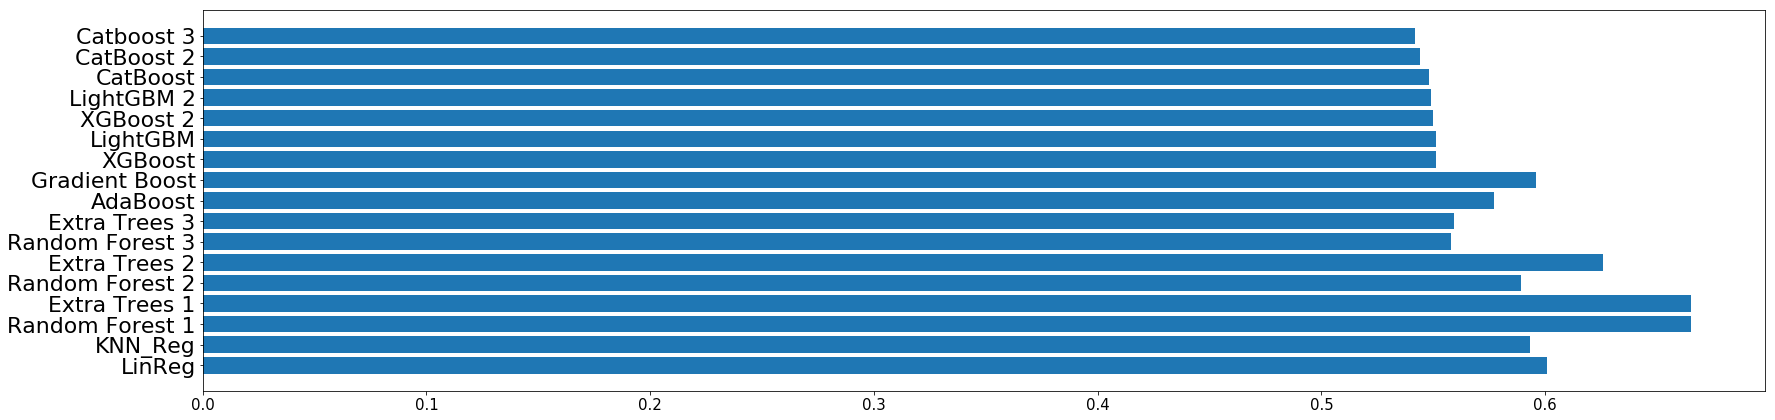

In [62]:
names = list(data.keys())
values = list(data.values())

#tick_label does the some work as plt.xticks()
plt.figure(figsize=(28,7))
plt.barh(range(len(data)),values,tick_label=names,align='center',)

In [58]:
sub12 = pd.read_csv('data/sample_submission.csv')
avg = (0.7*xgb_test_pred + 0.3*ctb_test_pred)
sub12.visitors = np.expm1(avg)
sub12.to_csv('submissions/avg.csv',index=False)

In [63]:
data = {'XGBoost':0.551,
          'LightGBM':0.551,
          'XGBoost 2':0.550,
          'LightGBM 2':0.549,
          'XGBoost 3':0.542,
          'LightGBM 3':0.547,
          'CatBoost':0.548,
          'CatBoost 2':0.544,
          'Catboost 3':0.542,
          'XGB+CATB':0.541}

<BarContainer object of 10 artists>

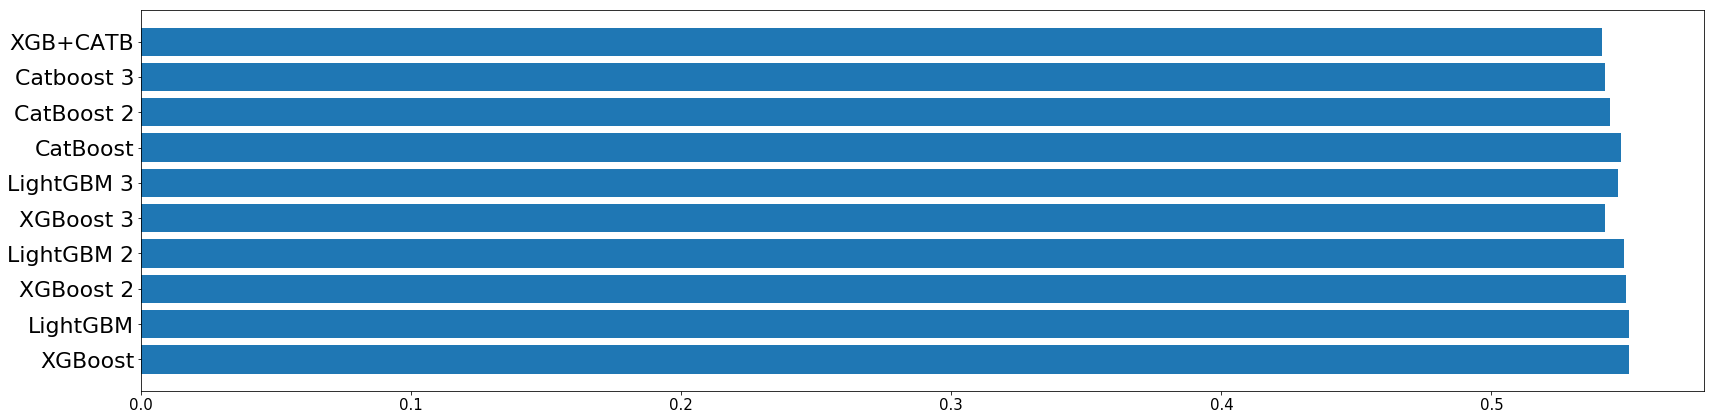

In [64]:
names = list(data.keys())
values = list(data.values())

#tick_label does the some work as plt.xticks()
plt.figure(figsize=(28,7))
plt.barh(range(len(data)),values,tick_label=names,align='center',)

### Bayesian Optimization 

In [352]:
from bayes_opt import BayesianOptimization

![title](images/bopt.png)

In [353]:
#Eliminate Some Features Unimportant Features
feat_dict = xgb_model.get_fscore()
sorted_feats = sorted(feat_dict.items(), key=lambda kv: kv[1])
new_cols = [f[0] for f in sorted_feats[5:-1]]

In [354]:
def prepare_xgb_data(seleceted_columns):
    df = train[seleceted_columns]
    y = np.log1p(train['visitors'])
    return df,y

In [355]:
def save_obj(obj, name ):
    with open('optim_results/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def xgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma,
                 reg_alpha,
                 reg_lambda,
                 max_delta_step):

    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
    params['max_depth'] = int(max_depth)
    params['subsample'] = max(min(subsample, 1), 0)
    params['gamma'] = max(gamma, 0)
    params['reg_alpha'] = max(reg_alpha, 0)
    params['reg_lamda'] = max(reg_lambda, 0)
    params['max_delta_step'] = int(max_delta_step)

    
    folds = KFold(n_splits= 5, shuffle=True, random_state=1881)
    oof_preds = np.zeros(train_df.shape[0])
    feats = train_df.columns
    rmse_scores = np.zeros(folds.n_splits)

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], labels)):
        train_x, train_y = train_df[feats].iloc[train_idx], labels.iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], labels.iloc[valid_idx]


        clf = xgb.XGBRegressor(**params)
        
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'rmse', verbose= 0, early_stopping_rounds= 200)
        
        
        rmse_scores[n_fold]=mean_squared_error(valid_y,clf.predict(valid_x, ntree_limit=clf.best_iteration))

        del clf, train_x, train_y, valid_x, valid_y

    return -np.mean(rmse_scores)

In [356]:
if __name__ == '__main__':
    train_df,labels = prepare_xgb_data(new_cols)
    base_mean = np.mean(np.log1p(train['visitors']))

    num_rounds = 1000
    random_state = 666
    num_iter = 10
    init_points = 5
    params = {
        'n_estimators':num_rounds,
        'learning_rate': 0.05,
        'silent': 1,
        'eval_metric': 'auc',
        'verbose_eval': False,
        'seed': random_state,
        'n_jobs':48,
        'base_score':base_mean
    }

    xgbBO = BayesianOptimization(xgb_evaluate, {'min_child_weight': (1, 20),
                                                'colsample_bytree': (0.5, 1),
                                                'max_depth': (2, 8),
                                                'subsample': (0.5, 1),
                                                'gamma': (0, 10),
                                                'reg_alpha': (0, 5),
                                                'reg_lambda': (0, 5),
                                                'max_delta_step':(2,15)
                                                })

    xgbBO.maximize(init_points=init_points, n_iter=num_iter)
    
    save_obj(xgbBO.res,'xgb_bopt_results')
    print("Search Resuls Saved!")

|   iter    |  target   | colsam... |   gamma   | max_de... | max_depth | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -0.2505   |  0.8013   |  0.9672   |  11.3     |  7.378    |  2.144    |  1.899    |  1.177    |  0.6308   |
|  2        | -0.257    |  0.5235   |  4.615    |  2.188    |  3.161    |  10.72    |  2.914    |  2.946    |  0.613    |
|  3        | -0.2536   |  0.6352   |  6.487    |  10.97    |  7.121    |  15.58    |  2.849    |  3.834    |  0.7641   |
|  4        | -0.2537   |  0.5248   |  3.856    |  8.879    |  5.035    |  17.35    |  1.648    |  2.294    |  0.8134   |
|  5        | -0.2539   |  0.8504   |  2.619    |  12.23    |  4.254    |  12.12    |  4.049    |  3.722    |  0.9132   |
|  6        | -0.2603   |  0.7598   |  9.668    |  14.97    |  2.188    |  2.347    |  1.573    |  0.3646   |  0.5572   |
|  7        | -0.2494   

In [377]:
xgbBO.max['params']

{'colsample_bytree': 0.8348256175376576,
 'gamma': 0.6189782739910854,
 'max_delta_step': 13.44106935464896,
 'max_depth': 7.946974388695891,
 'min_child_weight': 19.542053230827374,
 'reg_alpha': 4.371545223183943,
 'reg_lambda': 0.8191216549349994,
 'subsample': 0.8173965813810311}

In [361]:
optimized_params = {'base_score':np.mean(np.log1p(train['visitors'])),
                    'n_jobs':48,
                    'learning_rate':0.05,
                    'colsample_bytree': 0.8348256175376576,
  'gamma': 0.6189782739910854,
  'max_delta_step': 13,
  'max_depth': 8,
  'min_child_weight': 19.542053230827374,
  'reg_alpha': 4.371545223183943,
  'reg_lambda': 0.8191216549349994,
  'subsample': 0.8173965813810311}

In [362]:
train_matrix = xgb.DMatrix(train[new_cols],label=np.log1p(train['visitors']))

In [363]:
xgb_model_opt = xgb.train(optimized_params,train_matrix,num_boost_round=1000)

In [364]:
test_matrix = xgb.DMatrix(test[new_cols])
xgb_opt_test_pred = xgb_model_opt.predict(test_matrix)

In [365]:
sub13 = pd.read_csv('data/sample_submission.csv')
sub13.visitors = np.expm1(xgb_opt_test_pred)
sub13.to_csv('submissions/bayes_xgb_3.csv',index=False)

In [366]:
data = {'XGBoost With Tuning and Reduced Features':0.537,
        'XGBoost With Tuning':0.538,
        'XGBoost Without Tuning':0.542}

<BarContainer object of 3 artists>

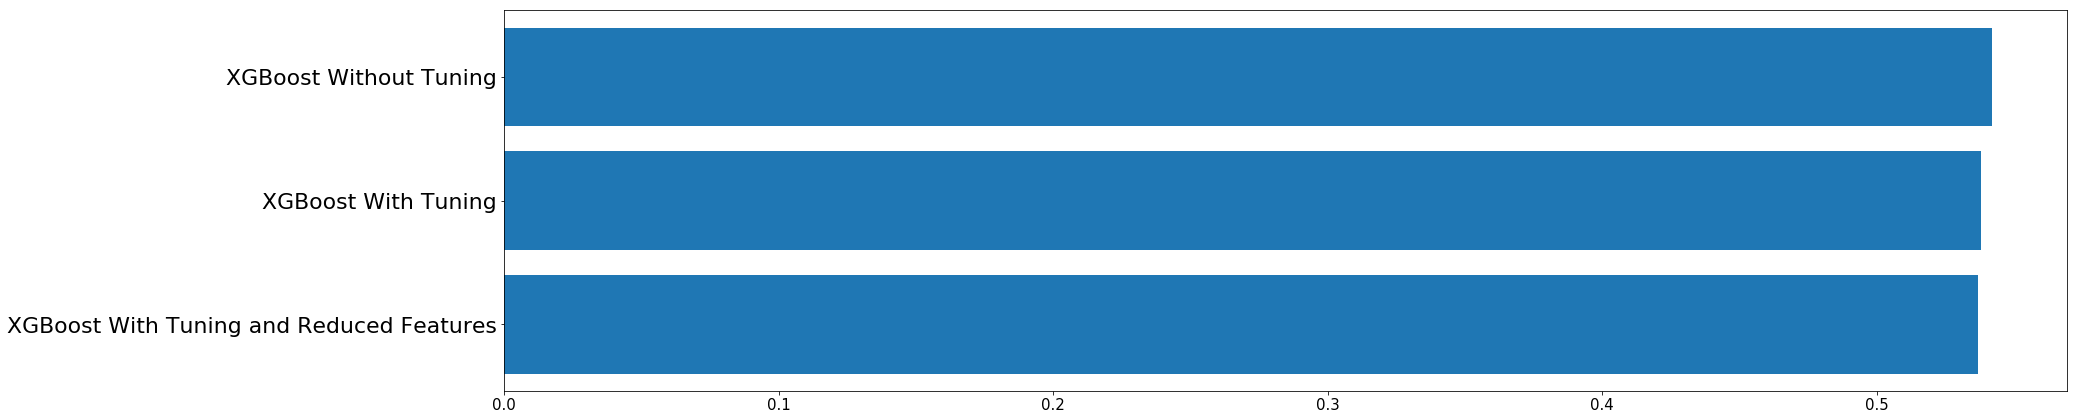

In [367]:
names = list(data.keys())
values = list(data.values())

#tick_label does the some work as plt.xticks()
plt.figure(figsize=(28,7))
plt.barh(range(len(data)),values,tick_label=names,align='center',)

### Stacked Ensemble

- Learning the weights for weighed averaging.
- Linear combination of base model predictions.
- Base learner predictions treated as features.
- Hyper parameter tuning for all base level and second stage regressor. Time consuming.
- Second model learns **“How predictions from the individual regressors contribute the ground truth?”**


![title](images/stack1.png)

In [117]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_152-release"; OpenJDK Runtime Environment (build 1.8.0_152-release-1056-b12); OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)
  Starting server from /home/dorukhan/anaconda2/envs/richmansworld/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp675o_d2s
  JVM stdout: /tmp/tmp675o_d2s/h2o_dorukhan_started_from_python.out
  JVM stderr: /tmp/tmp675o_d2s/h2o_dorukhan_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Istanbul
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.3
H2O cluster version age:,1 day
H2O cluster name:,H2O_from_python_dorukhan_4359sn
H2O cluster total nodes:,1
H2O cluster free memory:,13.98 Gb
H2O cluster total cores:,48
H2O cluster allowed cores:,48
H2O cluster status:,"accepting new members, healthy"


![title](images/h2o.png)

In [118]:
h2o_train = train.copy()
h2o_train.visitors = np.log1p(h2o_train.visitors)
h2o_cols = col.copy()
h2o_cols.append('visitors')

In [119]:
train_data = h2o.H2OFrame(h2o_train[h2o_cols])
test_data = h2o.H2OFrame(test[col])

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [120]:
y = 'visitors'

In [121]:
aml = H2OAutoML(max_runtime_secs = 3600, seed = 42,stopping_metric='RMSE' ,project_name = "restaurant_visitor_prediction",stopping_rounds=10,nfolds=5)

In [122]:
aml.train(y=y,training_frame=train_data)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [123]:
aml.leaderboard

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20181223_163224,0.235115,0.484887,0.235115,0.355806,0.15145
StackedEnsemble_BestOfFamily_AutoML_20181223_163224,0.23705,0.486878,0.23705,0.35756,0.151931
XGBoost_grid_1_AutoML_20181223_163224_model_1,0.238043,0.487897,0.238043,0.358847,0.152264
XGBoost_grid_1_AutoML_20181223_163224_model_2,0.238447,0.48831,0.238447,0.359141,0.152347
GBM_4_AutoML_20181223_163224,0.238843,0.488716,0.238843,0.359161,0.152461
XGBoost_2_AutoML_20181223_163224,0.238988,0.488864,0.238988,0.359792,0.152476
GBM_grid_1_AutoML_20181223_163224_model_1,0.239659,0.48955,0.239659,0.359936,0.152703
GBM_5_AutoML_20181223_163224,0.239763,0.489656,0.239763,0.359818,0.152757
XGBoost_grid_1_AutoML_20181223_163224_model_3,0.240178,0.490079,0.240178,0.360949,0.152833
GBM_3_AutoML_20181223_163224,0.242232,0.492171,0.242232,0.362066,0.153385


In [125]:
aml_pred=aml.predict(test_data).as_data_frame().values

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [126]:
sub14 = pd.read_csv('data/sample_submission.csv')
sub14.visitors = np.expm1(aml_pred)
sub14.to_csv('submissions/aml.csv',index=False)

In [127]:
h2o.cluster().shutdown()

H2O session _sid_91ba closed.


In [249]:
data = {'XGBoost':0.551,
          'LightGBM':0.551,
          'XGBoost 2':0.550,
          'LightGBM 2':0.549,
          'XGBoost 3':0.542,
          'LightGBM 3':0.547,
          'CatBoost':0.548,
          'CatBoost 2':0.544,
          'Catboost 3':0.542,
          'XGB+CATB':0.541,
          'AutoML 30min':0.534,
          'AutoML 60min':0.531}

<BarContainer object of 12 artists>

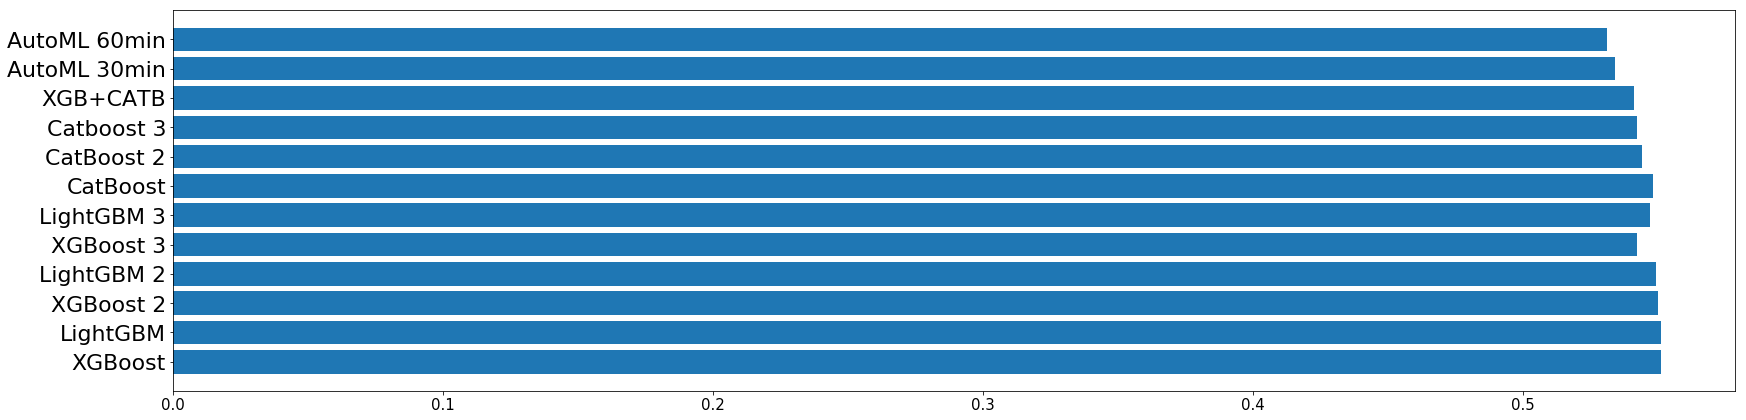

In [252]:
names = list(data.keys())
values = list(data.values())

#tick_label does the some work as plt.xticks()
plt.figure(figsize=(28,7))
plt.barh(range(len(data)),values,tick_label=names,align='center',)

In [131]:
data = {'Simple Linear Regression':0.601,
        'AutoML 60min':0.531}

<BarContainer object of 12 artists>

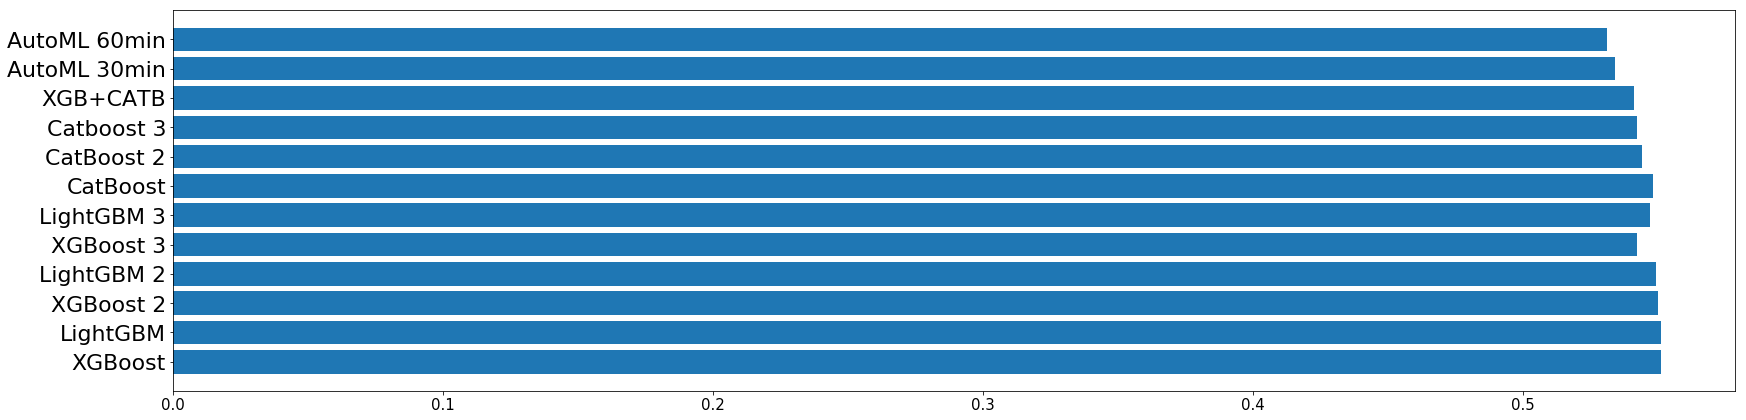

In [253]:
names = list(data.keys())
values = list(data.values())

#tick_label does the some work as plt.xticks()
plt.figure(figsize=(28,7))
plt.barh(range(len(data)),values,tick_label=names,align='center',)

- Result: Jumped over 718 people in Leaderboard as a result of a fast "train and try" process

### Representations Learned with SimpleNN

In [273]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_152-release"; OpenJDK Runtime Environment (build 1.8.0_152-release-1056-b12); OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)
  Starting server from /home/dorukhan/anaconda2/envs/richmansworld/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp5bmdr254
  JVM stdout: /tmp/tmp5bmdr254/h2o_dorukhan_started_from_python.out
  JVM stderr: /tmp/tmp5bmdr254/h2o_dorukhan_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Istanbul
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.3
H2O cluster version age:,2 days
H2O cluster name:,H2O_from_python_dorukhan_f850al
H2O cluster total nodes:,1
H2O cluster free memory:,13.98 Gb
H2O cluster total cores:,48
H2O cluster allowed cores:,48
H2O cluster status:,"accepting new members, healthy"


In [274]:
train_feats = np.load('data/nn_bottlenect.npz')
test_feats = np.load('data/test_features_nn.npz')

In [275]:
train_feats.files, test_feats.files

(['X_train', 'Y_train'], ['X_test'])

In [276]:
bott_train_X = train_feats['X_train']
bott_train_y = train_feats['Y_train'].reshape(-1,1)
bott_test_X = test_feats['X_test']

In [277]:
bott_train = np.hstack((bott_train_X,bott_train_y))

In [278]:
bott_train_df = h2o.H2OFrame(bott_train)
bott_test_df = h2o.H2OFrame(bott_test_X)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [225]:
bott_train_df.head()

C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63
0,0.0458015,0.156006,0.15894,0.0639269,0.926471,0,0,0,0,0,0,0,0,0,0,0,0.00116268,0.773691,0.3212,0.47499,1,0,1,0,0,0.180784,0.133332,0.102446,0.0532507,0.222575,0.0488308,0.0441353,0.0145012,-0.0407622,-0.137708,0.00118015,-0.288709,0.052508,-0.0857039,-0.180733,-0.10133,0.0338394,0.0332804,0.00380765,-0.00686579,0.0327886,0.358422,0.232635,-0.302932,0.0787565,0.41431,-0.0150595,0.0355257,-0.0711283,0.0561992,-0.064285,-0.334297,0.259185,0.0564278,-0.34677,0.258098,3.2581
0,0.0458015,0.156006,0.15894,0.0639269,0.926471,0,0,0,0,0,0,0,0,0,0,0,0.00184091,0.773691,0.3212,0.47499,1,0,1,0,0,0.180784,0.133332,0.102446,0.0532507,0.222575,0.0488308,0.0441353,0.0145012,-0.0407622,-0.137708,0.00118015,-0.288709,0.052508,-0.0857039,-0.180733,-0.10133,0.0338394,0.0332804,0.00380765,-0.00686579,0.0327886,0.358422,0.232635,-0.302932,0.0787565,0.41431,-0.0150595,0.0355257,-0.0711283,0.0561992,-0.064285,-0.334297,0.259185,0.0564278,-0.34677,0.258098,3.46574
0,0.0458015,0.156006,0.15894,0.0639269,0.926471,0,0,0,0,0,0,0,0,0,0,0,0.00251914,0.773691,0.3212,0.47499,1,0,1,0,0,0.180784,0.133332,0.102446,0.0532507,0.222575,0.0488308,0.0441353,0.0145012,-0.0407622,-0.137708,0.00118015,-0.288709,0.052508,-0.0857039,-0.180733,-0.10133,0.0338394,0.0332804,0.00380765,-0.00686579,0.0327886,0.358422,0.232635,-0.302932,0.0787565,0.41431,-0.0150595,0.0355257,-0.0711283,0.0561992,-0.064285,-0.334297,0.259185,0.0564278,-0.34677,0.258098,3.21888
0,0.0458015,0.156006,0.15894,0.0639269,0.926471,0,0,0,0,0,0,0,0,0,0,0,0.00988276,0.773691,0.3212,0.47499,1,0,1,0,0,0.180784,0.133332,0.102446,0.0532507,0.222575,0.0488308,0.0441353,0.0145012,-0.0407622,-0.137708,0.00118015,-0.288709,0.052508,-0.0857039,-0.180733,-0.10133,0.0338394,0.0332804,0.00380765,-0.00686579,0.0327886,0.358422,0.232635,-0.302932,0.0787565,0.41431,-0.0150595,0.0355257,-0.0711283,0.0561992,-0.064285,-0.334297,0.259185,0.0564278,-0.34677,0.258098,2.94444
0,0.0458015,0.156006,0.15894,0.0639269,0.926471,0,0,0,0,0,0,0,0,0,0,0,0.010561,0.773691,0.3212,0.47499,1,0,1,0,0,0.180784,0.133332,0.102446,0.0532507,0.222575,0.0488308,0.0441353,0.0145012,-0.0407622,-0.137708,0.00118015,-0.288709,0.052508,-0.0857039,-0.180733,-0.10133,0.0338394,0.0332804,0.00380765,-0.00686579,0.0327886,0.358422,0.232635,-0.302932,0.0787565,0.41431,-0.0150595,0.0355257,-0.0711283,0.0561992,-0.064285,-0.334297,0.259185,0.0564278,-0.34677,0.258098,3.49651
0,0.0458015,0.156006,0.15894,0.0639269,0.926471,0,0,0,0,0,0,0,0,0,0,0,0.0112392,0.773691,0.3212,0.47499,1,0,1,0,0,0.180784,0.133332,0.102446,0.0532507,0.222575,0.0488308,0.0441353,0.0145012,-0.0407622,-0.137708,0.00118015,-0.288709,0.052508,-0.0857039,-0.180733,-0.10133,0.0338394,0.0332804,0.00380765,-0.00686579,0.0327886,0.358422,0.232635,-0.302932,0.0787565,0.41431,-0.0150595,0.0355257,-0.0711283,0.0561992,-0.064285,-0.334297,0.259185,0.0564278,-0.34677,0.258098,2.89037
0,0.0458015,0.156006,0.15894,0.0639269,0.926471,0,0,0,0,0,0,0,0,0,0,0,0.0119174,0.773691,0.3212,0.47499,1,0,1,0,0,0.180784,0.133332,0.102446,0.0532507,0.222575,0.0488308,0.0441353,0.0145012,-0.0407622,-0.137708,0.00118015,-0.288709,0.052508,-0.0857039,-0.180733,-0.10133,0.0338394,0.0332804,0.00380765,-0.00686579,0.0327886,0.358422,0.232635,-0.302932,0.0787565,0.41431,-0.0150595,0.0355257,-0.0711283,0.0561992,-0.064285,-0.334297,0.259185,0.0564278,-0.34677,0.258098,3.09104
0,0.0458015,0.156006,0.15894,0.0639269,0.926471,0,0,0,0,0,0,0,0,0,0,0,0.0194749,0.773691,0.3212,0.47499,1,0,1,0,0,0.180784,0.133332,0.102446,0.0532507,0.222575,0.0488308,0.0441353,0.0145012,-0.0407622,-0.137708,0.00118015,-0.288709,0.052508,-0.0857039,-0.180733,-0.10133,0.0338394,0.0332804,0.00380765,-0.00686579,0.0327886,0.358422,0.232635,-0.302932,0.0787565,0.41431,-0.0150595,0.0355257,-0.0711283,0.0561992,-0.0

In [279]:
y = 'C63'

In [281]:
aml = H2OAutoML(max_runtime_secs = 3600*5, seed = 42,stopping_metric='RMSE' ,project_name = "restaurant_visitor_prediction_2",stopping_rounds=10,nfolds=5)

In [282]:
aml.train(y=y,training_frame=bott_train_df)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [283]:
aml.leaderboard

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20181224_020639,0.23002,0.479604,0.23002,0.352499,0.149934
StackedEnsemble_BestOfFamily_AutoML_20181224_020639,0.230295,0.479891,0.230295,0.352815,0.149999
XGBoost_grid_1_AutoML_20181224_020639_model_4,0.230348,0.479946,0.230348,0.352887,0.150038
XGBoost_grid_1_AutoML_20181224_020639_model_1,0.231893,0.481552,0.231893,0.354369,0.150481
XGBoost_grid_1_AutoML_20181224_020639_model_8,0.231955,0.481618,0.231955,0.354337,0.150479
XGBoost_grid_1_AutoML_20181224_020639_model_3,0.231958,0.48162,0.231958,0.354424,0.150521
XGBoost_grid_1_AutoML_20181224_020639_model_12,0.232026,0.481691,0.232026,0.354467,0.150485
XGBoost_2_AutoML_20181224_020639,0.232137,0.481806,0.232137,0.354212,0.150487
XGBoost_grid_1_AutoML_20181224_020639_model_2,0.232185,0.481856,0.232185,0.35462,0.150553
XGBoost_grid_1_AutoML_20181224_020639_model_17,0.232318,0.481993,0.232318,0.354637,0.150591


In [286]:
aml_pred_2=aml.predict(bott_test_df).as_data_frame().values

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [287]:
sub15 = pd.read_csv('data/sample_submission.csv')
sub15.visitors = np.expm1(aml_pred_2)
sub15.to_csv('submissions/aml2.csv',index=False)

In [288]:
data = {'Simple Linear Regression':0.601,
        'AutoML 60min':0.531,
        'NN features AutoML_Stacked Ensemble':0.519}

<BarContainer object of 3 artists>

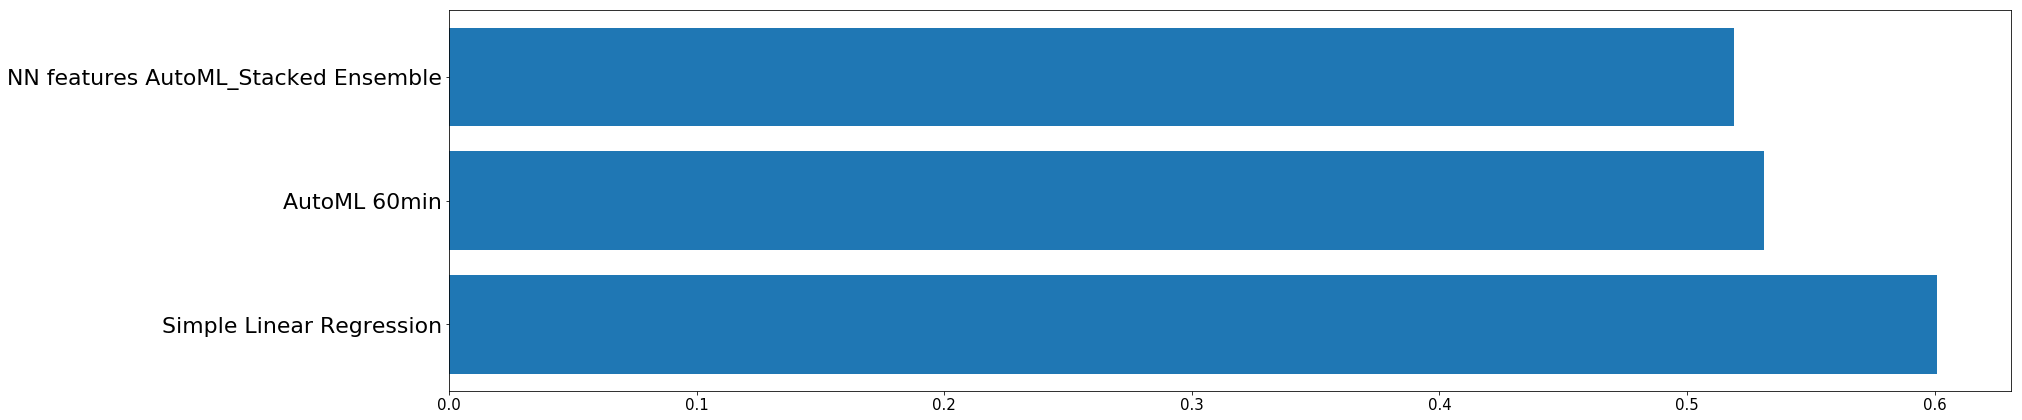

In [289]:
names = list(data.keys())
values = list(data.values())

#tick_label does the some work as plt.xticks()
plt.figure(figsize=(28,7))
plt.barh(range(len(data)),values,tick_label=names,align='center',)

- Result: Passed 685 more!

In [368]:
h2o.cluster().shutdown()